# Import libraries

In [1]:
# you have to install ipython-autotime using 'pip install ipython-autotime'
%load_ext autotime

import gc
import IPython.display
import os
import datetime
from tqdm import tqdm_notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# in this project, the metric is rmse, not mse
from sklearn.metrics import mean_squared_error

# models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet

#SVR and KNeighborsRegressor is too slow
#from sklearn.svm import SVR
#from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

import lightgbm

seed = 180718

# Load datasets

In [2]:
sales = pd.read_csv('./dataset/sales_train.csv.gz')
shops = pd.read_csv('./dataset/shops.csv')
items = pd.read_csv('./dataset/items.csv')
item_cats = pd.read_csv('./dataset/item_categories.csv')
test = pd.read_csv("./dataset/test.csv.gz")

time: 2.63 s


# Analyze raw datasets

Let's start to anylyze basic information about give datasets.

In [ ]:
# make float data looks integer data
pd.options.display.float_format = '{:,.0f}'.format

sales.describe()

In [ ]:
test.describe()

We need to do simple calculations here. The number of shop_id is 60, and the number of item_id is 22,170. Therefore, the total number of combinations of them is 1,330,200. However, there are only 214,200 IDs in the test. It means that this competition only requires 16.1% of the all shop_id and item_id combinations.

We can use this fact in 3 ways.
1. get a prediction of the test IDs in the submission using full data in the training and the validation.
2. get a prediction of the test IDs in the validation and the submission using full data in the training.
3. Reduce data before training to make training short.

I think we should take 2 or 3. In the first way, the validation score can not be fitting to the test score. My strategy is using 3 till the validation and using 2 in the submission only. I think full data has other shops or other items, but it can give some information about how the price is going especially if I use RNN algorithms.

# Plan EDA(Exploratory data analysis)

I think item_price and item_cnt_day have interesting qualtiles and min-max values. First of all, item_cnt_day must not be zero value because sales data is record of something that occured in sales. However, the target is item_cnt_month, so it would be better to analyze monthly data of item_cnt. In the item, the max price is so much higher than others. I'm not sure but, it's possible to use the extream price for prediction.

My plans is as below.

1. reduce data using test id combinations
2. aggregate the total item_cnt_month of shops month by month
3. aggregate the total item_cnt month of items month by month
4. aggregate the total item_cnt_month month by month

The purpose of them is to know if there are correlations between them and if there are patterns in time flow.

# Make utilities to submit

Utility function makes codes simple, so it's good to make these functions

In [3]:
def make_submission_df(all_prediction):
    df = test.merge(all_prediction, on=["shop_id", "item_id"], how="left")[["ID", "item_cnt_month"]]
    df["item_cnt_month"] = df["item_cnt_month"].fillna(0).clip(0, 20)
    
    return df

def make_submission_file(df, name=""):
    df.to_csv("./submission/%s.csv" % name, sep=",", index=False)
    
def make_submission(all_prediction, name=""):
    make_submission_file(make_submission_df(all_prediction), name)

time: 8.67 ms


# Make benchmarks

There should be benchmarks to measure my prediction's quality, so I made very simple ones. I think it should be done in first phase.

In [ ]:
# sample = pd.read_csv('./dataset/sample_submission.csv.gz')
# make_submission_file(sample, 'sample_value')

# sample['item_cnt_month'] = 0
# make_submission_file(sample, 'zero_value')

# previous_month = sales[sales["date_block_num"] == 33].groupby(["shop_id", "item_id"], as_index=False).item_cnt_day.sum().rename(columns={"item_cnt_day": "item_cnt_month"})
# make_submission(previous_month, "previous_month_value")

# del sample, previous_month

# Benchmark results

* sample value(all 0.5): 1.23646
* zero value: 1.25011
* previous month value: 1.16777

# Reduce data using test id combinations

In [ ]:
reduced_sales = sales.merge(test)
reduced_sales = reduced_sales.drop('ID', axis=1)
reduced_sales.describe()

Before reducing data, the total number of rows is 2,935,849. Now, the amount of data is reduced to 41.7%.
It means that test data is not randomly picked in all combinations of shop_id and item_id.
One of the possible scenarios is that the host of this competition chose test targets in combinations that appeared in the sales data, not in all combinations.

# Analyze combinations of shop_id and item_id

In [ ]:
full_comb = sales[['shop_id', 'item_id']]
full_comb = full_comb.drop_duplicates()
display(full_comb.describe())
display('unique value of shop_id: ' + str(len(full_comb.shop_id.unique())))
display('unique value of item_id: ' + str(len(full_comb.item_id.unique())))

In [ ]:
reduced_comb = reduced_sales[['shop_id', 'item_id']]
reduced_comb = reduced_comb.drop_duplicates()
display(reduced_comb.describe())
display('unique value of shop_id: ' + str(len(reduced_comb.shop_id.unique())))
display('unique value of item_id: ' + str(len(reduced_comb.item_id.unique())))

In [ ]:
display(test.describe())
display('unique value of shop_id: ' + str(len(test.shop_id.unique())))
display('unique value of item_id: ' + str(len(test.item_id.unique())))

| data | full | reduced | test |
|------|------| ------- | ---- |
| shop_id | 60 | 42 | 42 |
| item_id | 21,807 | 4,716 | 5100 |
| total | 424,124 | 111,404 | 214,200 |
| possible | 1,308,420 | 198,072 | 214,200 |
| ratio | 32.4% | 56.2% | 100% |

Our target is 214,200 combination. However, in the reduced data, there is only 4,716 unique item_ids. It means that 385 item was not sold in that period. In the combination, there is more zero sold combinations. It's almost half of the test combinations. In the full data set, zero sold combination ratios is abount 1/3. This is not so big gap between them. I think the important is the number of item_id. The test unique item_id is almost 1/4 of full data item_id. If we use one hot encoding for item_id, we can use only 1/4 of memory.

I focused on something else. The total number of the combinations in the test is 214,200, but 111,404 in the reduced dataset. It means that only about half of combinations exists in sales data. One more data selection options is selecting only data in 111,404 combinations. I'm going to use the test dataset first, and then I'll use smaller and bigger one.

In [ ]:
del full_comb, reduced_comb, reduced_sales

# Get applicable dataset to models

First, define a useful function to save a memory.

In [4]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

time: 7.5 ms


### 1. Get base data form

The form should have 'shop_id', 'item_id', 'date_block_num' because the required form of this competition is 'ID' made of 'shop_id' and 'item_id', and 'item_cnt_month'.

In [5]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

time: 1.24 ms


In [6]:
gb = sales.groupby(index_cols, as_index=False).sum().rename(columns={'item_cnt_day':'month_sale'})
# 가격 정보를 사용할 것인지 아직 모름. 사용한다면 살려야 함.
gb = gb.drop('item_price', axis=1)

df1 = pd.DataFrame({'shop_id': np.sort(shops.shop_id.unique()), 'key':np.zeros(len(shops.shop_id.unique()))})
df2 = pd.DataFrame({'item_id': np.sort(items.item_id.unique()), 'key':np.zeros(len(items.item_id.unique()))})
df3 = pd.DataFrame({'date_block_num': np.sort(gb.date_block_num.unique()), 'key':np.zeros(len(gb.date_block_num.unique()))})

df = df1.merge(df2).merge(df3)

del df1, df2, df3

df = df.drop('key', axis=1)

time: 10.8 s


In [7]:
df = df.merge(gb, how='outer').fillna(0)

del gb

df.head()

df = downcast_dtypes(df)

gc.collect()

151

time: 19.5 s


In [ ]:
pd.options.display.float_format = '{:,.3f}'.format

# Clip (0, 20) before making something

In [8]:
df.month_sale = df.month_sale.values.clip(0,20)

time: 378 ms


# montly sale in the shop

In [9]:
shop_gb = df.groupby(['shop_id', 'date_block_num'], as_index=False).sum()
shop_gb = shop_gb.rename(columns={'month_sale':'month_sale_shop'})
shop_gb = shop_gb.drop(columns=['item_id'])
shop_gb.head()

,shop_id,date_block_num,month_sale_shop
0,0,0,5411.0
1,0,1,5820.0
2,0,2,0.0
3,0,3,0.0
4,0,4,0.0


time: 6.48 s


In [10]:
# 총합을 주는게 좋을까 전체 샵의 수로 나누는게 좋을까? 샵에 대해서는 어쩔까?
item_gb = df.groupby(['item_id', 'date_block_num'], as_index=False).sum()
item_gb = item_gb.rename(columns={'month_sale':'month_sale_item'})
item_gb = item_gb.drop(columns=['shop_id'])
item_gb.head()

,item_id,date_block_num,month_sale_item
0,0,0,0.0
1,0,1,0.0
2,0,2,0.0
3,0,3,0.0
4,0,4,0.0


time: 7.65 s


In [11]:
df = df.merge(shop_gb, how='left').fillna(0)
df.head()

,shop_id,item_id,date_block_num,month_sale,month_sale_shop
0,0,0,0,0.0,5411.0
1,0,0,1,0.0,5820.0
2,0,0,2,0.0,0.0
3,0,0,3,0.0,0.0
4,0,0,4,0.0,0.0


time: 9.46 s


In [12]:
df = df.merge(item_gb, how='left').fillna(0)
df.head()

,shop_id,item_id,date_block_num,month_sale,month_sale_shop,month_sale_item
0,0,0,0,0.0,5411.0,0.0
1,0,0,1,0.0,5820.0,0.0
2,0,0,2,0.0,0.0,0.0
3,0,0,3,0.0,0.0,0.0
4,0,0,4,0.0,0.0,0.0


time: 17.3 s


# montly sale in the item

### 2. Make lag features

In [13]:
#12개월 전체를 할 수도 있고 일부를 할 수도 있다. 난 여기서 일부만 사용
#ensembling에선 1~5,12를 사용

shift_range = [1,2,3,12]

time: 2.63 ms


In [14]:
# List of columns that we will use to create lags
cols_to_rename = list(df.columns.difference(index_cols)) 

lag_df = df

for month_shift in tqdm_notebook(shift_range):
    train_shift = lag_df[index_cols + cols_to_rename].copy()
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    lag_df = lag_df.merge(train_shift, how='outer')
    del train_shift
    lag_df = downcast_dtypes(lag_df)
    gc.collect()

HBox(children=(IntProgress(value=0, max=4), HTML(value='')))


time: 4min 54s


- 위 작업이 시간이 오래걸리므로 csv나 npy파일로 만든 후에 저장했다가 부르는건 어떨까?
- validation용 traing set과 test용 traing set을 분리시킨 후에 파이프 라인을 만들어서 코드를 깔끔하게 만들자
- 작업이 끝나면 Knn feature와 mean encoding 방법을 적용할 방법을 생각해보자
- 마지막은 ensemble을 해보자

### 3. Trim lag_df

In [15]:
# Don't use old data from year 2013(because we use 12 months lag data in the target)
# to make submission 33 -> 34

valid_last = 33
test_last = 34

lag_df = lag_df[12 <= lag_df.date_block_num]
lag_df = lag_df[lag_df.date_block_num <= test_last]
lag_df = lag_df.fillna(0)
lag_df = downcast_dtypes(lag_df)

time: 26.3 s


### 4. Save lag_df

In [16]:
# lag_df.to_csv("full_lag_df.csv", sep=",", index=False)

time: 15.4 ms


### 5. load lag_df

In [17]:
# lag_df = pd.read_csv("full_lag_df.csv")
# lag_df = downcast_dtypes(lag_df)

time: 3.28 ms


In [18]:
#shift_range = [1,2,3,12]
# List of all lagged features
fit_cols = [col for col in lag_df.columns if col[-1] in [str(item) for item in shift_range]] 
# We will drop these at fitting stage
to_drop_cols = list(set(list(lag_df.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 

time: 10.3 ms


In [19]:
lag_df.head()

,shop_id,item_id,date_block_num,month_sale,month_sale_shop,month_sale_item,month_sale_lag_1,month_sale_item_lag_1,month_sale_shop_lag_1,month_sale_lag_2,month_sale_item_lag_2,month_sale_shop_lag_2,month_sale_lag_3,month_sale_item_lag_3,month_sale_shop_lag_3,month_sale_lag_12,month_sale_item_lag_12,month_sale_shop_lag_12
12,0,0,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5411.0
13,0,0,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5820.0
14,0,0,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,0,0,15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,0,0,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


time: 49.2 ms


# Feature engineering part

1. all item cnt
2. all shop cnt
3. KNN features
4. Mean encoding
5. time series analysis

# train / valid / test split

In [ ]:
# Save `date_block_num`, as we can't use them as features, but will need them to split the dataset into parts 
dates = lag_df['date_block_num']
valid_block = 33
test_block = 34

dates_train = dates[dates <  valid_block]
dates_valid  = dates[dates == valid_block]
dates_test = dates[dates == test_block]

X_train = lag_df.loc[dates <  valid_block].drop(to_drop_cols, axis=1).values
y_train = lag_df.loc[dates <  valid_block, 'month_sale'].values.clip(0,20)

valid = lag_df.loc[dates == valid_block]
valid = test.merge(valid, how='left').fillna(0).drop('ID', axis=1)
X_valid =  valid.drop(to_drop_cols, axis=1).values
y_valid =  valid['month_sale'].values.clip(0,20)

X_full_train = lag_df.loc[dates <  test_block].drop(to_drop_cols, axis=1).values
y_full_train = lag_df.loc[dates <  test_block, 'month_sale'].values.clip(0,20)
X_test = lag_df.loc[dates == test_block].drop(to_drop_cols, axis=1).values
#X_test = test.merge(lag_df.loc[dates == test_block], how='left').fillna(0).drop(to_drop_cols + ['ID'], axis=1)

# Define this competition metric as a function

# First level models 

1. half: 1,2,3,6,9,12
2. 1/3: 1,2,3,12
3. half2: 1-5, 12
4. 1/3_2: 1,2,3,4

- LinearRegression
    1. yonly
        1. 1-12: 0.933236273624 => 1.09279
        2. half: 0.931571168513 - 16.4 s
        3. 1/3: 0.9262253239 - 11.5 s
    2. y + shop_y + 1/3: 0.925771859478 - 30 s
    3. item_y: 0.924365311084 - 40.8 s
    4. clip_month_sale: 0.902686261502 - 47.1 s => 1.03034
    5. clip(0,40): 0.908622732715 - 51 s
- ElasticNet
    1. yonly
        1. 1-12: 0.912161949243 => 1.04670
        2. half: 0.91242207741 - 21.7 s
        3. 1/3: 0.910106878399 - 12.3 s
    2. y + shop_y + 1/3: 0.908298623397 - 1min
    3. item_y: 0.918947709243 - 1min 24s
    4. clip_month_sale: 0.997504443555 - 53.8 s => 1.12730
    5. clip(0,40): 0.986036525298 - 54.2 s
- RandomForestRegressor
    1. yonly 
        1. 1-12(max_depth=3): 0.980893498007
        2. half(max_depth=10): 0.903594473573 - 3min 19s
        3. 1/3: 0.907014417171 - 2min 40s, 0.906545092257 - 2min 44s(seed)
    2. y + shop_y + 1/3: 0.904931700085 - 4min 56s
    3. item_y: 0.900006389736 - 6min 21s
    4. clip_month_sale
        1. n5d10: 0.884558830043 - 6min 54s
        2. n50
            - d13: 0.880630637901 - 58min 53s
            - d14: 0.880980458672 - 1h 1min 33s
            - d15: 0.880768923211 - 1h 4min 59s
            - d16: 0.881246216635 - 1h 8min 3s
        3. n1dNone: 1.08458987675 - 4min 31s
    5. clip(0,40): 0.888263907278 - 6min 33s
- ExtraTreesRegressor
    1. yonly
        1. 1-12(n=10, max_depth=5): 0.980940782649
        2. half(max_depth=20): 0.907416246054 - 2min 6s
        3. 1/3: 0.907362455722 - 1min 35s, 0.905973938144 - 1min 44s, 0.907614968974 - 1min 51s(seed)
    3. item_y: 0.901501525093 - 7min 42s
    4. clip_month_sale: 0.886585196886 - 9min 6s (not anymore.. only RF)
        - n50d13: 0.883138230251 - 48min 6s
- lightgbm
    1. yonly
        1. 1-12: 0.893098000611 => 1.02475
        2. half: 0.894044244386 - 4min 27s
        3. 1/3: 0.893822409009 - 3min 36s
    3. item_y: 0.886242950874 - 5min 43s => 1.01865
    4. clip_month_sale
        - ** 1/3: 0.878756133684 - 5min 3s => 1.01201 **
        - 1/3_2:  0.878191759896 - 4min 51s => 1.01532
        - half:   0.875355556599 - 5min 51s => 1.01262
        - half2:  0.876777727805 - 6min 6s => 1.01255
        
    5. clip(0,40): 0.878402461649 - 4min 55s


validation score를 믿을만하다고 생각했었는데 feature변경하면서 하다보니 안맞는 부분이 있군..
- 카테고리 정보 활용?
- 이름 정보 활용?

In [20]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(np.clip(y_true, 0, 20), np.clip(y_pred, 0, 20)))

def get_valid_rmse(reg):
    reg.fit(X_train, y_train)
    pred = reg.predict(X_valid)
    print(rmse(pred, y_valid))
    
def get_valid_rmse2(reg, i):
    reg.fit(X_train, y_train)
    pred = reg.predict(X_valid)
    print(i + ': ' + str(rmse(pred, y_valid)))
    
def get_prediction(reg):
    reg.fit(X_full_train, y_full_train)
    pred = reg.predict(X_test)
    return pred

time: 33 ms


# Random Forest 실험 결과 

- n-1 d-5: 0.907364982577
- n-1 d-8: 0.89459729871
- n-1 d-10: 0.895443025682
- n-1 d-13: 0.907934495971
- n-1 d-15: 0.922931800723
- n-2 d-5: 0.905816024133
- n-2 d-8: 0.892378300441
- n-2 d-10: 0.891449670099
- n-2 d-13: 0.894940465977
- n-2 d-15: 0.906524026616
- n-3 d-5: 0.904804930646
- n-3 d-8: 0.891574099542
- n-3 d-10: 0.888751033308
- n-3 d-13: 0.890498987202
- n-3 d-15: 0.897281007082
- n-4 d-5: 0.904425711382
- n-4 d-8: 0.891026194803
- n-4 d-10: 0.886066862395
- n-4 d-13: 0.887052497829
- n-4 d-15: 0.890746942068
- n-5 d-5: 0.904218191743
- n-5 d-8: 0.889983926703
- n-5 d-10: 0.884558830043
- n-5 d-13: 0.885515521105
- n-5 d-15: 0.88867127083
- n-10 d-5: 0.903706002099
- n-10 d-8: 0.889455372439
- n-10 d-10: 0.883724366696
- n-10 d-13: 0.882571987825
- n-10 d-15: 0.885643626759
- n-20 d-5: 0.903612684362
- n-20 d-8: 0.888859116109
- n-20 d-10: 0.883396754691
- n-20 d-13: 0.881203453387
- n-20 d-15: 0.881972022241

time: 3h 47min 29s

# Simple ensembling structure

- ensemble two model
    1. Linear Regression(0.90268626150226106), lightgbm(0.87875613368405925) =>
        1. last 3
            1. Linear Regression: 0.879674
            2. lightgbm: 0.947700
            3. Random Forest: 0.881135
        2. last 6
            1. Linear Regression: 0.877625
            2. lightgbm: 0.959168
            3. Random Forest: 0.878719
        3. last 6 + X_train
            1. Linear Regression: 0.876767
            2. lightgbm: 0.882532
            3. Random Forest: 0.877934
            4. ElasticNet(alpha=0.01): 0.888654
- ensemble three model
    1. Linear Regression, lightgbm, KnnRegressor
        - winner in two models
- ensemble five models
    1. Linear Regression, ElasticNet, lightgbm, Random Forest, KnnRegressor
        - ?

In [22]:
# Save `date_block_num`, as we can't use them as features, but will need them to split the dataset into parts 
dates = lag_df['date_block_num']
valid_block = 33
test_block = 34

dates_train = dates[dates <  valid_block]
dates_valid  = dates[dates == valid_block]
dates_test = dates[dates == test_block]

X_train = lag_df.loc[dates <  valid_block].drop(to_drop_cols, axis=1)
y_train = lag_df.loc[dates <  valid_block, 'month_sale'].values.clip(0,20)

valid = lag_df.loc[dates == valid_block]
valid = test.merge(valid, how='left').fillna(0).drop('ID', axis=1)
X_valid =  valid.drop(to_drop_cols, axis=1)
y_valid =  valid['month_sale'].values.clip(0,20)

X_full_train = lag_df.loc[dates <  test_block].drop(to_drop_cols, axis=1)
y_full_train = lag_df.loc[dates <  test_block, 'month_sale'].values.clip(0,20)
X_test = lag_df.loc[dates == test_block].drop(to_drop_cols, axis=1).values
#X_test = test.merge(lag_df.loc[dates == test_block], how='left').fillna(0).drop(to_drop_cols + ['ID'], axis=1)

time: 20.3 s


In [23]:
lr = LinearRegression()
lr.fit(X_train.values, y_train)
pred_lr = lr.predict(X_valid.values)

rmse(pred_lr, y_valid)

0.90268626150226106

time: 45.3 s


In [25]:
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }



lgb = lightgbm.train(lgb_params, lightgbm.Dataset(X_train.values, label=y_train), 100)
pred_lgb = lgb.predict(X_valid)

rmse(lgb_pred, y_valid)

0.87875613368405925

time: 4min 52s


In [27]:
pred_lgb = lgb.predict(X_valid)

time: 2.63 s


In [28]:
X_test_level2 = np.c_[pred_lr, pred_lgb]

time: 7.59 ms


In [49]:
#원래는 27~32였는데 시간이 오래걸릴거 같아서 줄임
level2_date_blocks = [27,28,29,30,31,32]
dates_train_level2 = dates_train[dates_train.isin(level2_date_blocks)]

# That is how we get target for the 2nd level dataset
y_train_level2 = y_train[dates_train.isin(level2_date_blocks)]

time: 947 ms


In [50]:
# And here we create 2nd level feeature matrix, init it with zeros first
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])

# Now fill `X_train_level2` with metafeatures
for cur_block_num in level2_date_blocks:
    
    print(cur_block_num)
    
    '''
        1. Split `X_train` into parts
           Remember, that corresponding dates are stored in `dates_train` 
        2. Fit linear regression 
        3. Fit LightGBM and put predictions          
        4. Store predictions from 2. and 3. in the right place of `X_train_level2`. 
           You can use `dates_train_level2` for it
           Make sure the order of the meta-features is the same as in `X_test_level2`
    '''
    
    #  YOUR CODE GOES HERE
    lr = LinearRegression()
    lr.fit(X_train[dates_train < cur_block_num].values, y_train[dates_train < cur_block_num])
    pred_lr_level2 = lr.predict(X_train[dates_train == cur_block_num].values)
    
    lgb = lightgbm.train(lgb_params, lightgbm.Dataset(X_train[dates_train < cur_block_num], label=y_train[dates_train < cur_block_num]), 100)
    pred_lgb_level2 = lgb.predict(X_train[dates_train == cur_block_num].values)
    
    X_train_level2[dates_train_level2.isin([cur_block_num]), 0] = pred_lr_level2.copy()
    X_train_level2[dates_train_level2.isin([cur_block_num]), 1] = pred_lgb_level2.copy()

27
28
29
30
31
32
time: 30min 47s


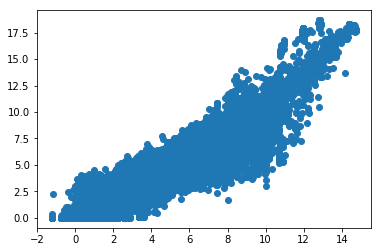

time: 1min 1s


In [51]:
plt.scatter(X_train_level2[:,0], X_train_level2[:,1])

In [63]:
X_train_plus_level2 = np.c_[X_train[dates_train.isin(level2_date_blocks)].values, X_train_level2]

time: 3.15 s


In [64]:
X_train_plus_level2.shape

(7981200, 16)

time: 6.07 ms


In [77]:
meta_model = lightgbm.train(lgb_params, lightgbm.Dataset(X_train_plus_level2, label=y_train_level2), 100)

time: 1min 18s


In [81]:
meta_model = RandomForestRegressor(max_depth=5)

meta_model.fit(X_train_plus_level2, y_train_level2)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

time: 3min 50s


In [75]:
valid_plus = np.c_[X_valid.values, stacked_valid_pred]

time: 57.8 ms


In [87]:
meta_model = ElasticNet(alpha=0.01)

meta_model.fit(X_train_plus_level2, y_train_level2)

ElasticNet(alpha=0.01, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

time: 57.6 s


In [88]:
train_preds = meta_model.predict(X_train_plus_level2)
rmse_train_stacking = rmse(y_train_level2, train_preds)

valid_preds = meta_model.predict(valid_plus)
rmse_valid_stacking = rmse(y_valid, valid_preds)

print('Train rmse for stacking is %f' % rmse_train_stacking)
print('Test  rmse for stacking is %f' % rmse_valid_stacking)

Train rmse for stacking is 0.360417
Test  rmse for stacking is 0.888654
time: 370 ms


In [ ]:
#TODO: pred만 보내서 submission 만들도록 함수 만들기

pred = ensemble_pred
dd = lag_df[dates == test_block]
dd.month_sale = pred
dd = dd[['shop_id', 'item_id', 'month_sale']]
dd = dd.rename(columns={'month_sale':'item_cnt_month'})
make_submission(dd, 'ensemble_lr_lgb_')

# Submit to kaggle

This cell automatically submits the submission file to kaggle. However, it should be carefully executed because the submitting opportunities are limited.
- remove '#' before submitting
- add a meaningful message to a submission

In [ ]:
#!kaggle competitions submit -c competitive-data-science-final-project -f ./submission/lgb_onetofour_data.csv -m "lgb with clipped train data"

# Check public score

In [ ]:
!kaggle competitions submissions -c competitive-data-science-final-project

For sure, it scores better with more data han less data. One more thing I want to try is using full data in training and validating with only test data id combinations.

TODO
- clipping [0, 20] in training (done)
- using category, shop information, name(translated in discussion)
- Check one hot encoding and label encoding
- using scipy sparse matrix representation
- elaborate valdiation scheme not only using 33 to valdiate(how about 5 folds moving window?) => 계산 시간이 너무 많이 걸릴거같은데..ㅠㅠ
- add feature(season?) 해볼까.. 
- can I use scipy.sparse here?